Librerias

In [3]:
import scipy.io
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import datetime
import csv
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt, decimate, freqz
from scipy.signal import stft
from scipy import stats
import funciones as mifu

Probemos ver el espacio de frecuencias y que pasa con el filtrado y downsampling

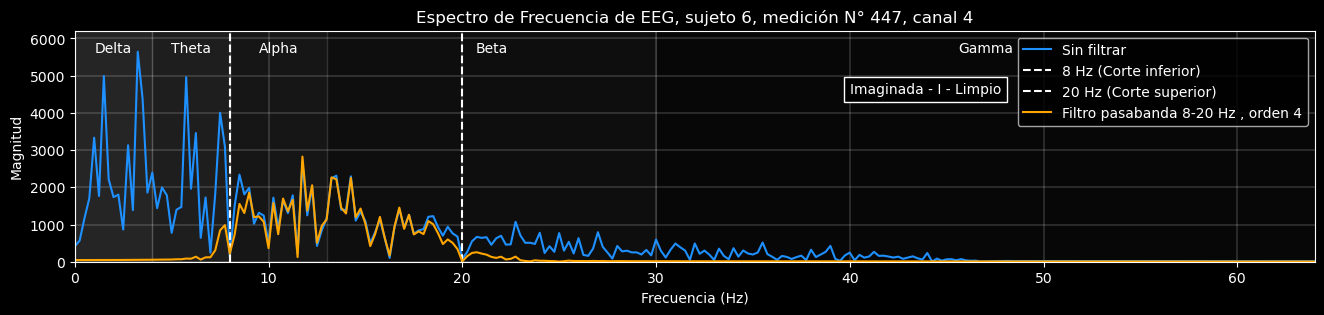

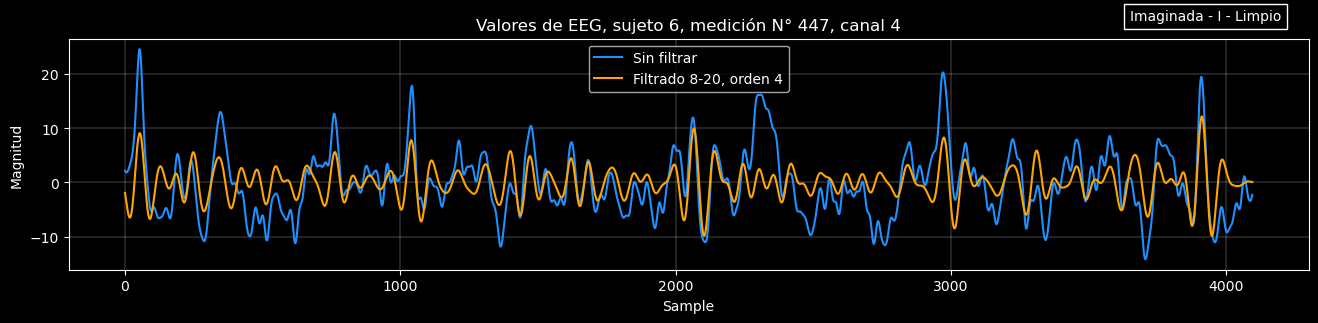

In [92]:
sujeto = random.randint(1, 15)
datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)
fs = 1024
dato = random.randint(0, datos_ordenados[0].shape[0] - 1)
canal = random.randint(0, 5)

# Veamos el espacio de frecuencias de estos datos, y los contrastamos con el de la señal tras ser filtrada, usamos solo los valores positivos
magnitudes_fft_sin_filtrar = np.abs(np.fft.fft(datos_ordenados[0][dato][canal*4096:(canal + 1)*4096]))
frecuencias_sin_filtrar = np.fft.fftfreq(len(datos_ordenados[0][dato][canal*4096:(canal + 1)*4096]), d = 1/fs)
magnitudes_fft_sin_filtrar = magnitudes_fft_sin_filtrar[:len(frecuencias_sin_filtrar)//2]
frecuencias_sin_filtrar = frecuencias_sin_filtrar[:len(frecuencias_sin_filtrar)//2]

# Filtro
corte_bajo = 8
corte_alto = 20
orden = 4
tipo = 'band'
datos_filtrados = mifu.filtrar_butterworth(datos_ordenados, tipo, corte_bajo, corte_alto, fs, orden)
magnitudes_fft_filtrado = np.abs(np.fft.fft(datos_filtrados[0][dato][canal*4096:(canal + 1)*4096]))
frecuencias_filtrado = np.fft.fftfreq(len(datos_filtrados[0][dato][canal*4096:(canal + 1)*4096]), d = 1/fs)
magnitudes_fft_filtrado = magnitudes_fft_filtrado[:len(frecuencias_sin_filtrar)//2]
frecuencias_filtrado = frecuencias_filtrado[:len(frecuencias_sin_filtrar)//2]

indice = (datos_filtrados[1][dato] - 1).astype(int)
ref_etiq = [['Imaginada', 'Pronunciada'][indice[0]], ['A', 'E', 'I', 'O', 'U', 'Arriba', 'Abajo', 'Adelante', 'Atras', 'Derecha', 'Izquierda'][indice[1]], ['Limpio', 'Parpadeo'][indice[2]]]
ref_etiq = str(ref_etiq[0]) + ' - ' + str(ref_etiq[1]) + ' - ' + str(ref_etiq[2])

# Quiero graficar todas las mediciones sobre un mismo sujeto
# plt.style.use('dark_background')
# plt.figure(figsize=(16, 3))
# for i in range(6):
#     plt.plot(np.concatenate(datos_ordenados[0][:,(i*4096):((i+1)*4096)]), label = 'Canal ' + str(i+1))
# plt.title("Valores de EEG, sujeto " + str(sujeto))
# plt.xlabel("Sample")
# plt.ylabel("Magnitud")
# plt.legend()
# plt.xlim(-100, np.concatenate(datos_ordenados[0][:,:4096]).shape[0] + 100)
# plt.show()

# Grafico frecuencias
plt.figure(figsize=(16, 3))
plt.style.use('dark_background')
ondas_cerebrales = [
    {"nombre": "Delta", "inicio": 0, "fin": 4, 'tr': 0.15},
    {"nombre": "Theta", "inicio": 4, "fin": 8, 'tr': 0.12},
    {"nombre": "Alpha", "inicio": 8, "fin": 13, 'tr': 0.09},
    {"nombre": "Beta", "inicio": 13, "fin": 30, 'tr': 0.06},
    {"nombre": "Gamma", "inicio": 30, "fin": 64, 'tr': 0.03}
]
for onda in ondas_cerebrales:
    plt.axvspan(onda["inicio"], onda["fin"], color = 'white', alpha = onda['tr'])
    x_pos = (onda["inicio"] + onda["fin"]) / 2
    y_pos = 1.05*max(magnitudes_fft_sin_filtrar)
    plt.text(x_pos, y_pos, onda["nombre"], fontsize=10, ha='center', va='top', color='white')


plt.plot(frecuencias_sin_filtrar, magnitudes_fft_sin_filtrar, label = 'Sin filtrar', color = 'dodgerblue')
plt.xlim(0, 64)
plt.title("Espectro de Frecuencia de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(dato + 1) + ', canal ' + str(canal))
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.ylim(0, max(magnitudes_fft_sin_filtrar)*1.1)
if tipo == 'band':
    plt.axvline(corte_bajo, color='white', linestyle='--', label=f'{corte_bajo} Hz (Corte inferior)')
    plt.axvline(corte_alto, color='white', linestyle='--', label=f'{corte_alto} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado, magnitudes_fft_filtrado, label = ('Filtro pasabanda ' + str(corte_bajo) + '-' + str(corte_alto) + ' Hz , orden ' + str(orden)), color = 'orange')
elif tipo == 'low':
    plt.axvline(corte_alto, color='white', linestyle='--', label=f'{corte_alto} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado, magnitudes_fft_filtrado, label = ('Filtro pasa bajos ' + str(corte_alto) + ' Hz , orden ' + str(orden)), color = 'orange')
elif tipo == 'high':
    plt.axvline(corte_bajo, color='white', linestyle='--', label=f'{corte_bajo} Hz (Corte inferior)')
    plt.plot(frecuencias_filtrado, magnitudes_fft_filtrado, label = ('Filtro pasa altos ' + str(corte_bajo) + ' Hz , orden ' + str(orden)), color = 'orange')
plt.text(40, max(magnitudes_fft_sin_filtrar)*0.8, ref_etiq, fontsize=10, bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

# Grafico valores
plt.figure(figsize=(16, 3))
plt.style.use('dark_background')
plt.plot(datos_ordenados[0][dato][canal*4096:(canal + 1)*4096], label = 'Sin filtrar', color = 'dodgerblue')
plt.plot(datos_filtrados[0][dato][canal*4096:(canal + 1)*4096], label = ('Filtrado ' + str(corte_bajo) + '-' + str(corte_alto) + ', orden ' + str(orden)), color = 'orange')
plt.title("Valores de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(dato + 1) + ', canal ' + str(canal))
plt.xlabel("Sample")
plt.ylabel("Magnitud")
plt.text(4200, 1.3*max(np.max(datos_ordenados[0][dato][canal*4096:(canal + 1)*4096]), np.max(datos_filtrados[0][dato][canal*4096:(canal + 1)*4096])), ref_etiq, fontsize=10, ha='right', va='top', bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

In [1]:
np.concatenate(datos_ordenados[0][:,4094:4096]).shape

NameError: name 'np' is not defined

datos_divididos es una lista de forma [entrenamiento, prueba], siendo ambas listas tambien, cada una de forma [datos, etiquetas].

La parte de entrenamiento tiene la misma cantidad de datos para cada tipo de etiqueta. Ademas, tanto datos como etiquetas, son listas de longitud igual a la cantidad de etiquetas que da el tipo de prediccion (11 si predice estimulo).

Cada elemento de estas listas es un array con los datos o etiquetas correspondientes a cada medicion con esa etiqueta.
Entonces, la lista de datos de entrenamiento, por ejemplo, tiene esta forma:
    
    11 arrays de n mediciones cada una (de una misma etiqueta cada una), donde cada medicion es un array de 24576 valores, dado al concatenarse los 6 canales de 4096 valores cada uno.

# ANALISIS TIEMPO-FRECUENCIA
Consideramos la variacion espectral en el tiempo

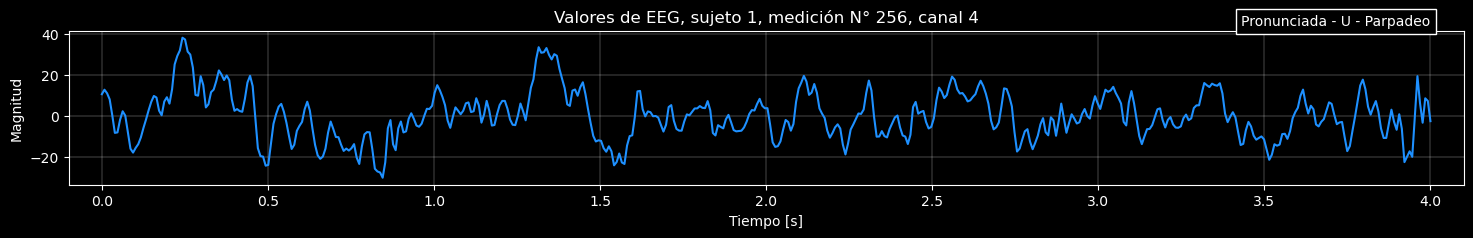

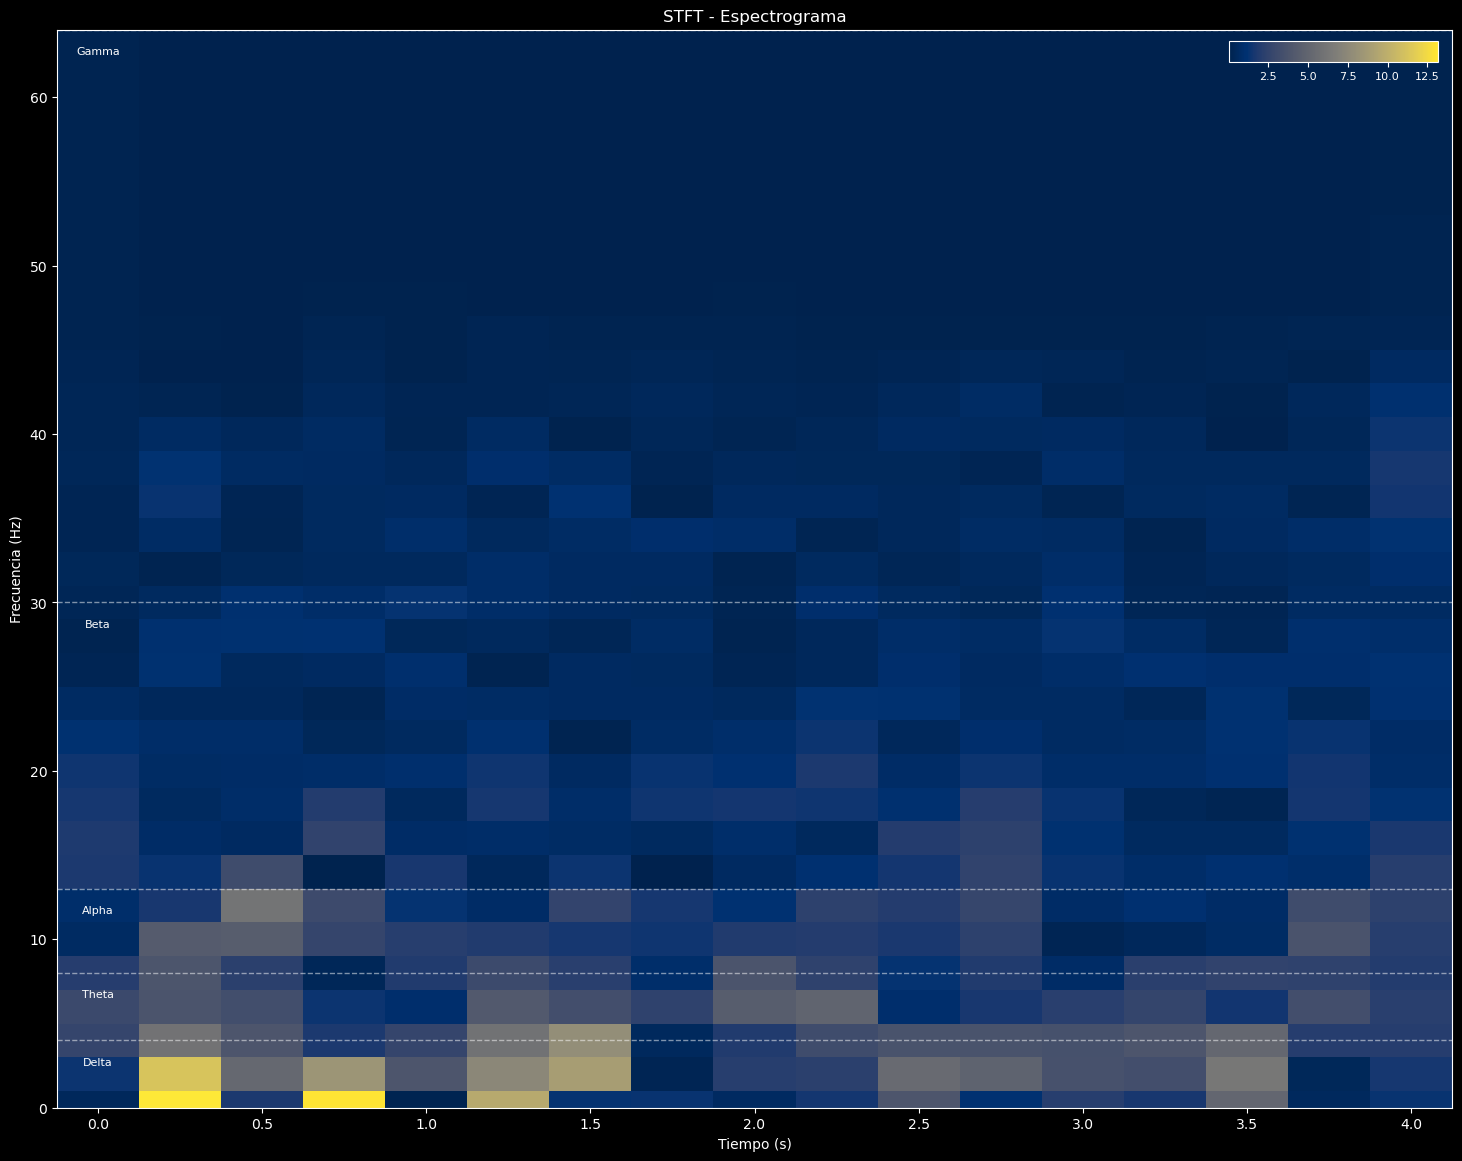

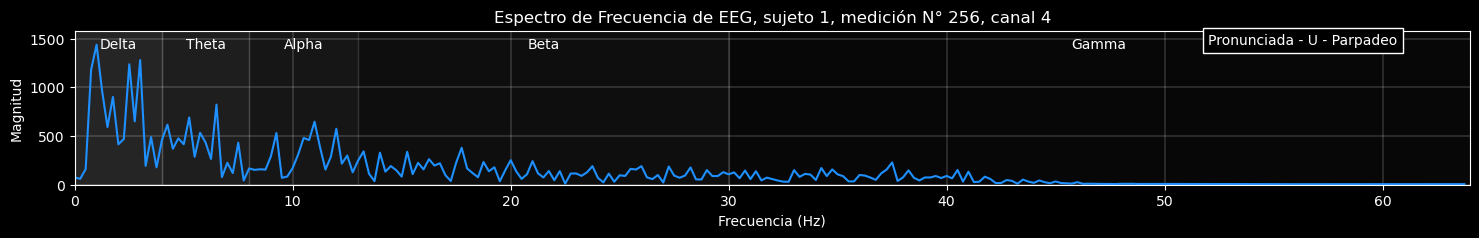

(561,) (17, 33)


In [9]:
sujeto = random.randint(1, 15)
# sujeto = 14
datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)
fs = 1024
dato = random.randint(0, datos_ordenados[0].shape[0] - 1)
# dato = 634
canal = random.randint(0, 5)
# canal = 3

indice = (datos_ordenados[1][dato] - 1).astype(int)
ref_etiq = [['Imaginada', 'Pronunciada'][indice[0]], ['A', 'E', 'I', 'O', 'U', 'Arriba', 'Abajo', 'Adelante', 'Atras', 'Derecha', 'Izquierda'][indice[1]], ['Limpio', 'Parpadeo'][indice[2]]]
ref_etiq = str(ref_etiq[0]) + ' - ' + str(ref_etiq[1]) + ' - ' + str(ref_etiq[2])

###########################################################################################################################################################
# Le hago un downsampling a los datos

fs_original = 1024
fs_nueva = 128
factor = fs_original // fs_nueva
datos_downsampleados = [np.empty((datos_ordenados[0].shape[0], fs_nueva*4*6)), datos_ordenados[1]]

for i in range(6):  # Se hace por canal en cada una de las mediciones
    datos_downsampleados[0][:,fs_nueva*4*i:fs_nueva*4*(i + 1)] = decimate(datos_ordenados[0][:,4096*i:4096*(i + 1)], factor, axis = 1, zero_phase = True)

###########################################################################################################################################################
# Medicion

plt.figure(figsize=(18, 2))
plt.style.use('dark_background')
plt.plot(np.linspace(0, 4, 4*fs_nueva), datos_downsampleados[0][dato][canal*4*fs_nueva:(canal + 1)*4*fs_nueva], color = 'dodgerblue')
plt.title("Valores de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(dato + 1) + ', canal ' + str(canal))
plt.xlabel("Tiempo [s]")
plt.ylabel("Magnitud")
plt.text(4.0, 1.3*np.max(datos_downsampleados[0][dato][canal*4*fs_nueva:(canal + 1)*4*fs_nueva]), 
         ref_etiq, fontsize=10, ha='right', va='top', bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.xlim(-0.1, 4.1)
plt.show()

###########################################################################################################################################################
# Calcula la STFT

ventana_temporal = 64
f, t_stft, Zxx = mifu.calcular_stft(datos_downsampleados[0][dato][canal*4*fs_nueva:(canal + 1)*4*fs_nueva],
                                     fs = fs_nueva, nperseg = ventana_temporal, noverlap = ventana_temporal/2)

f_max = 64
cmap = 'cividis'
if f_max:
    idx_max = np.where(f <= f_max)[0][-1]  # Encuentra el índice del f_max
    f = f[:idx_max + 1]  # Filtra las frecuencias
    Zxx = Zxx[:idx_max + 1, :]  # Filtra la matriz espectral
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(18, 14))
pcm = ax.pcolormesh(t_stft, f, np.abs(Zxx), shading = 'nearest', cmap = cmap)

# Crear un eje dentro del gráfico para la barra de color (posición relativa)
cax = ax.inset_axes([0.84, 0.97, 0.15, 0.02])
cbar = plt.colorbar(pcm, cax = cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 8)
# Límites de ondas cerebrales
bandas = {
    "Delta": 4,
    "Theta": 8,
    "Alpha": 13,
    "Beta": 30,
    "Gamma": 64
}
for label, freq in bandas.items():
    ax.axhline(y = freq, color = 'white', linestyle = 'dashed', alpha = 0.5, linewidth = 1)  # Línea horizontal
    ax.text(t_stft[0], freq - 1, label, color = 'white', fontsize = 8, verticalalignment = 'top', horizontalalignment = 'center')

ax.set_ylabel('Frecuencia (Hz)')
ax.set_xlabel('Tiempo (s)')
ax.set_title(f'STFT - Espectrograma')
ax.set_ylim(0, f_max)

plt.show()

###########################################################################################################################################################
# Espectro de frecuencias en todo el intervalo temporal

magnitudes_fft_sin_filtrar = np.abs(np.fft.fft(datos_downsampleados[0][dato][canal*4*fs_nueva:(canal + 1)*4*fs_nueva]))
frecuencias_sin_filtrar = np.fft.fftfreq(len(datos_downsampleados[0][dato][canal*4*fs_nueva:(canal + 1)*4*fs_nueva]), d = 1/fs_nueva)
magnitudes_fft_sin_filtrar = magnitudes_fft_sin_filtrar[:len(frecuencias_sin_filtrar)//2]
frecuencias_sin_filtrar = frecuencias_sin_filtrar[:len(frecuencias_sin_filtrar)//2]

plt.style.use('dark_background')
plt.figure(figsize=(18, 2))
ondas_cerebrales = [
    {"nombre": "Delta", "inicio": 0, "fin": 4, 'tr': 0.15},
    {"nombre": "Theta", "inicio": 4, "fin": 8, 'tr': 0.12},
    {"nombre": "Alpha", "inicio": 8, "fin": 13, 'tr': 0.09},
    {"nombre": "Beta", "inicio": 13, "fin": 30, 'tr': 0.06},
    {"nombre": "Gamma", "inicio": 30, "fin": 64, 'tr': 0.03}
]
for onda in ondas_cerebrales:
    plt.axvspan(onda["inicio"], onda["fin"], color = 'white', alpha = onda['tr'])
    x_pos = (onda["inicio"] + onda["fin"]) / 2
    y_pos = 1.05*max(magnitudes_fft_sin_filtrar)
    plt.text(x_pos, y_pos, onda["nombre"], fontsize=10, ha='center', va='top', color='white')

plt.plot(frecuencias_sin_filtrar, magnitudes_fft_sin_filtrar, color = 'dodgerblue')
plt.xlim(0, 64)
plt.title("Espectro de Frecuencia de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(dato + 1) + ', canal ' + str(canal))
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.ylim(0, max(magnitudes_fft_sin_filtrar)*1.1)
plt.text(52, 1.25*max(magnitudes_fft_sin_filtrar)*0.8, ref_etiq, fontsize=10, bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.show()

print(np.concatenate(np.log(np.abs(Zxx)).T).shape, (np.log(np.abs(Zxx)).T).shape)

Voy a probar hacer prediccion sobre los modulos cuadrados de la matriz de STFT y compararlo contra la prediccion cruda de los datos downsampleados.
Es importante el punto porque, aunque se esté haciendo un método diferente, las dimensiones quedan relativamente similares en la capa de entrada.

In [12]:
fecha1 = '07-01-2025'
hito1 = 'Hice un downsampling a 128Hz antes de nnormalizar. Sin filtro. Con dropout.'
fecha2 = '03-03-2025'
hito2 = 'Uso el modulo cuadrado de los valores de las matrices STFT como imput de los MLP despues de hacer downsampling. Sin filtro. Con dropout.'
N = 8
for sujeto in range(1, 16):
    datos = mifu.extraer(sujeto)
    datos_ordenados = mifu.ordenar(datos)
    fs_original = 1024
    fs_nueva = 128
    factor = fs_original // fs_nueva
    datos_downsampleados = [np.empty((datos_ordenados[0].shape[0], fs_nueva*4*6)), datos_ordenados[1]]
    for i in range(6):
        datos_downsampleados[0][:,fs_nueva*4*i:fs_nueva*4*(i + 1)] = decimate(datos_ordenados[0][:,4096*i:4096*(i + 1)], factor, axis = 1, zero_phase = True)
    # Hasta aca estan ordenados y downsampleados

    ventana_temporal = 64
    datos_stft = mifu.convertir_a_stft(datos_downsampleados, fs_nueva, 'hann', ventana_temporal, ventana_temporal/2)

    datos_aplanados = np.empty((datos_stft[0].shape[0], datos_stft[0].shape[1]*datos_stft[0].shape[2]*datos_stft[0].shape[3])).astype(np.complex128())
    aux = np.empty((datos_stft[0].shape[0], datos_stft[0].shape[1], datos_stft[0].shape[2]*datos_stft[0].shape[3])).astype(np.complex128())
    for i in range(datos_stft[0].shape[0]):
        for j in range(datos_stft[0].shape[1]):
            aux[i][j] = np.concatenate(datos_stft[0][i][j].T)
    for i in range(aux.shape[0]):
        datos_aplanados[i] = np.concatenate(aux[i])
    datos_aplanados = [datos_aplanados, datos_stft[1]]
    datos_aplanados2 = [np.abs(datos_aplanados[0]), datos_aplanados[1]]

    datos_normalizados1 = mifu.normalizar(datos_downsampleados)
    datos_normalizados2 = mifu.normalizar(datos_aplanados2)

    for prediccion in ['modalidad', 'estimulo', 'artefacto']:
        if prediccion == 'modalidad' or prediccion == 'artefacto':
            fraccion_entrenamiento = 0.40
            neuronas_salida = 2
        else:
            fraccion_entrenamiento = 0.25
            neuronas_salida = 11

        valores1 = []
        valores2 = []
        for n in range(N):
            semilla = random.randint(0, 999999)

            datos_divididos1 = mifu.dividir_datos(datos_normalizados1, fraccion_entrenamiento, prediccion, semilla)
            datos_divididos2 = mifu.dividir_datos(datos_normalizados2, fraccion_entrenamiento, prediccion, semilla)

            neuronas_entrada1 = datos_divididos1[0][0].shape[1]
            neuronas_entrada2 = datos_divididos2[0][0].shape[1]
            ocultas = [256, 128]
            epocas = 3000       # Al tener menos neuronas en la capa de entrada, puedo ponerle mas tiempo de entrenamiento
            plotear = 0         # Si es 1 grafica la perdida, si es 0 no lo hace
            tol = 1e-6
            ls = 0.0001
            datos_divididos1[0][0], datos_divididos1[0][1] = shuffle(datos_divididos1[0][0], datos_divididos1[0][1], random_state = semilla)
            datos_divididos2[0][0], datos_divididos2[0][1] = shuffle(datos_divididos2[0][0], datos_divididos2[0][1], random_state = semilla)

            dropout_ratio = 0.0     # Tuve que sacarle el dropout porque me cumplia el criterio de parada siempre
            modelo1 = mifu.MLP(neuronas_entrada1, ocultas, neuronas_salida, dropout_ratio)
            mifu.MLP.entrenar(modelo1, epocas, datos_divididos1[0][0], datos_divididos1[0][1], plotear, tol, ls)
            modelo2 = mifu.MLP(neuronas_entrada2, ocultas, neuronas_salida, dropout_ratio)
            mifu.MLP.entrenar(modelo2, epocas, datos_divididos2[0][0], datos_divididos2[0][1], plotear, tol, ls)

            precision1, predicciones1 = mifu.MLP.evaluar(modelo1, datos_divididos1[1][0], datos_divididos1[1][1])
            print(np.bincount(predicciones1), np.bincount(datos_divididos1[1][1]))
            precision2, predicciones2 = mifu.MLP.evaluar(modelo2, datos_divididos2[1][0], datos_divididos2[1][1])
            print(np.bincount(predicciones2), np.bincount(datos_divididos2[1][1]))
            valores1.append(precision1)
            valores2.append(precision2)

        error1 = np.std(valores1, ddof=1)/math.sqrt(N)
        valor1 = np.mean(valores1)
        arq1 = 'S' + str(sujeto) + '/' + 'minmax' + '/' + prediccion + '/' + str([neuronas_entrada1] + ocultas + [neuronas_salida]).replace(',','')
        mifu.registrar(valor1, error1, arq1, fecha1, hito1)

        error2 = np.std(valores2, ddof=1)/math.sqrt(N)
        valor2 = np.mean(valores2)
        arq2 = 'S' + str(sujeto) + '/' + 'minmax' + '/' + prediccion + '/' + str([neuronas_entrada2] + ocultas + [neuronas_salida]).replace(',','')
        mifu.registrar(valor2, error2, arq2, fecha2, hito2)


Se usara el 12% para entrenar al modelo.
Se usara el 12% para entrenar al modelo.
La precision del modelo es del 51.0%.
[280 320] [534  66]
La precision del modelo es del 75.5%.
[403 197] [534  66]
Se usara el 12% para entrenar al modelo.
Se usara el 12% para entrenar al modelo.
La precision del modelo es del 63.0%.
[364 236] [534  66]
La precision del modelo es del 81.33333%.
[448 152] [534  66]
Se usara el 12% para entrenar al modelo.
Se usara el 12% para entrenar al modelo.
La precision del modelo es del 57.83333%.
[341 259] [534  66]
La precision del modelo es del 79.0%.
[424 176] [534  66]
Se usara el 12% para entrenar al modelo.
Se usara el 12% para entrenar al modelo.
La precision del modelo es del 62.33333%.
[364 236] [534  66]
La precision del modelo es del 73.0%.
[388 212] [534  66]
Se usara el 12% para entrenar al modelo.
Se usara el 12% para entrenar al modelo.
La precision del modelo es del 64.0%.
[374 226] [534  66]
La precision del modelo es del 74.5%.
[395 205] [534  66

In [107]:
ruta = os.path.join('historial.csv')
with open(ruta, mode='r', newline='', encoding='latin-1') as archivo:
    lector_csv = csv.reader(archivo)
    datos = []
    for i in lector_csv:
        datos.append(i)

datos_arreglados = []
for i in datos:
    j = []
    j.append(float(i[0]))
    j.append(float(i[1]))
    k = i[2].split('/')
    k[3] = k[3][1:-1].split(' ')
    m = []
    for n in k[3]:
        m.append(int(n))
    j.append(int(k[0][1:]))
    j.append(k[1])
    j.append(k[2])
    j.append(m)
    j.append(i[3])
    j.append(i[4])
    datos_arreglados.append(j)
datos = datos_arreglados

datos = datos[450:585]

#################################################################################################################################################################
# Comparo las medias generales y les hago test de hipotesis todos contra todos

valores = []
for sujeto in range(1, 16):
    valores.append([])
    for prediccion in ['modalidad', 'estimulo', 'artefacto']:
        aux = []
        for i in datos:
            if i[2] == sujeto and i[4] == prediccion:
                aux.append([i[0], i[1]])
        valores[sujeto - 1].append(aux)
valores = np.array(valores)


prom_filtrando = np.mean(valores[:,1,:,0][:,0])
error_filtrando = math.sqrt(np.sum((valores[:,1,:,1][:,0]/15)**2) + (np.std(valores[:,1,:,0][:,0], ddof = 1)**2/15))
n_filtrado = 10
prom_downsampling = np.mean(valores[:,1,:,0][:,1])
error_downsampling = math.sqrt(np.sum((valores[:,1,:,1][:,1]/15)**2) + (np.std(valores[:,1,:,0][:,1], ddof = 1)**2/15))
n_downsampling = 8
prom_stft = np.mean(valores[:,1,:,0][:,2])
error_stft = math.sqrt(np.sum((valores[:,1,:,1][:,2]/15)**2) + (np.std(valores[:,1,:,0][:,2], ddof = 1)**2/15))
n_stft = 8
# print(prom_filtrando, error_filtrando)
# print(prom_downsampling, error_downsampling)
# print(prom_stft, error_stft)

alpha = 0.05
t_fd = (prom_filtrando - prom_downsampling) / np.sqrt((error_filtrando**2 / n_filtrado) + (error_downsampling**2 / n_downsampling))
t_ds = (prom_downsampling - prom_stft) / np.sqrt((error_stft**2 / n_stft) + (error_downsampling**2 / n_downsampling))
t_sf = (prom_stft - prom_filtrando) / np.sqrt((error_filtrando**2 / n_filtrado) + (error_stft**2 / n_stft))


df_fd = ((error_filtrando**2 / n_filtrado) + (error_downsampling**2 / n_downsampling))**2 / (
    ((error_filtrando**2 / n_filtrado)**2) / (n_filtrado - 1) + ((error_downsampling**2 / n_downsampling)**2) / (n_downsampling - 1))
df_ds = ((error_downsampling**2 / n_downsampling) + (error_stft**2 / n_stft))**2 / (
    ((error_downsampling**2 / n_downsampling)**2) / (n_downsampling - 1) + ((error_stft**2 / n_stft)**2) / (n_stft - 1))
df_sf = ((error_stft**2 / n_stft) + (error_filtrando**2 / n_filtrado))**2 / (
    ((error_stft**2 / n_stft)**2) / (n_stft - 1) + ((error_filtrando**2 / n_filtrado)**2) / (n_filtrado - 1))

p_value_fd = stats.t.sf(np.abs(t_fd), df_fd) * 2
p_value_ds = stats.t.sf(np.abs(t_ds), df_ds) * 2
p_value_sf = stats.t.sf(np.abs(t_sf), df_sf) * 2

p_value_fd, p_value_ds, p_value_sf  # Las 3 medias son significativamente diferentes entre si.

(np.float64(2.9359961446975627e-08),
 np.float64(1.7281089499052174e-05),
 np.float64(1.1708889697091735e-09))

In [51]:
N = 8
for sujeto in range(1, 16):
    datos = mifu.extraer(sujeto)
    datos_ordenados = mifu.ordenar(datos)
    fs_original = 1024
    fs_nueva = 128
    factor = fs_original // fs_nueva
    datos_downsampleados = [np.empty((datos_ordenados[0].shape[0], fs_nueva*4*6)), datos_ordenados[1]]
    for i in range(6):
        datos_downsampleados[0][:,fs_nueva*4*i:fs_nueva*4*(i + 1)] = decimate(datos_ordenados[0][:,4096*i:4096*(i + 1)], factor, axis = 1, zero_phase = True)
    datos_normalizados = mifu.normalizar(datos_downsampleados)
    for prediccion in ['estimulo']:
        if prediccion == 'modalidad' or prediccion == 'artefacto':
            fraccion_entrenamiento = 0.40
            neuronas_salida = 2
        else:
            fraccion_entrenamiento = 0.25
            neuronas_salida = 11

        valores = []
        for n in range(N):
            semilla = random.randint(0, 999999)

            datos_divididos = mifu.dividir_datos(datos_normalizados, fraccion_entrenamiento, prediccion, semilla)

            neuronas_entrada = datos_divididos[0][0].shape[1]
            ocultas = []
            epocas = 3000       # Al tener menos neuronas en la capa de entrada, puedo ponerle mas tiempo de entrenamiento
            plotear = 0         # Si es 1 grafica la perdida, si es 0 no lo hace
            tol = 1e-5
            ls = 0.0001
            datos_divididos[0][0], datos_divididos[0][1] = shuffle(datos_divididos[0][0], datos_divididos[0][1], random_state = semilla)

            dropout_ratio = 0.0     # Tuve que sacarle el dropout porque me cumplia el criterio de parada siempre
            modelo = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida, dropout_ratio)
            mifu.MLP.entrenar(modelo, epocas, datos_divididos[0][0], datos_divididos[0][1], plotear, tol, ls)

            precision, predicciones = mifu.MLP.evaluar(modelo, datos_divididos[1][0], datos_divididos[1][1])
            print(np.bincount(predicciones), np.bincount(datos_divididos[1][1]))
            valores.append(precision)

        error = np.std(valores, ddof=1)/math.sqrt(N)
        valor = np.mean(valores)
        arq = 'S' + str(sujeto) + '/' + 'minmax' + '/' + prediccion + '/' + str([neuronas_entrada] + ocultas + [neuronas_salida]).replace(',','')
        mifu.registrar(valor, error, arq, '05-03-2025', 'Downsampling pero en perceptron')

Se usara el 22% para entrenar al modelo.
La precision del modelo es del 13.29588%.
[46 47 44 68 33 58 57 41 42 43 55] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 12.35955%.
[36 35 52 53 80 42 61 38 48 52 37] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 10.48689%.
[52 48 56 33 53 44 57 45 46 41 59] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 14.41948%.
[53 49 43 40 65 40 35 46 47 62 54] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 14.60674%.
[50 54 44 44 53 70 44 41 52 52 30] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 13.85768%.
[43 59 54 55 55 50 45 29 42 56 46] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 14.98127%.

Poniendo detalle en el downsampling

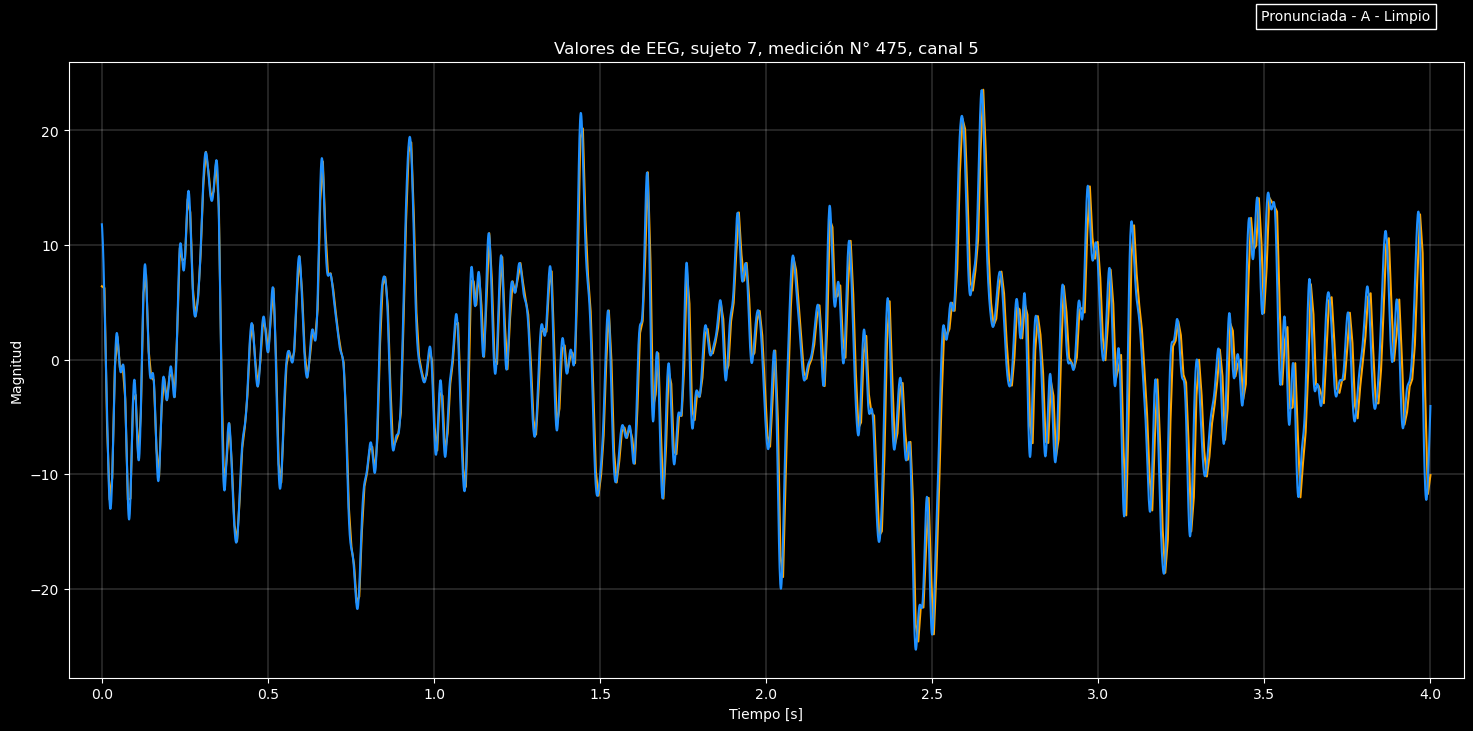

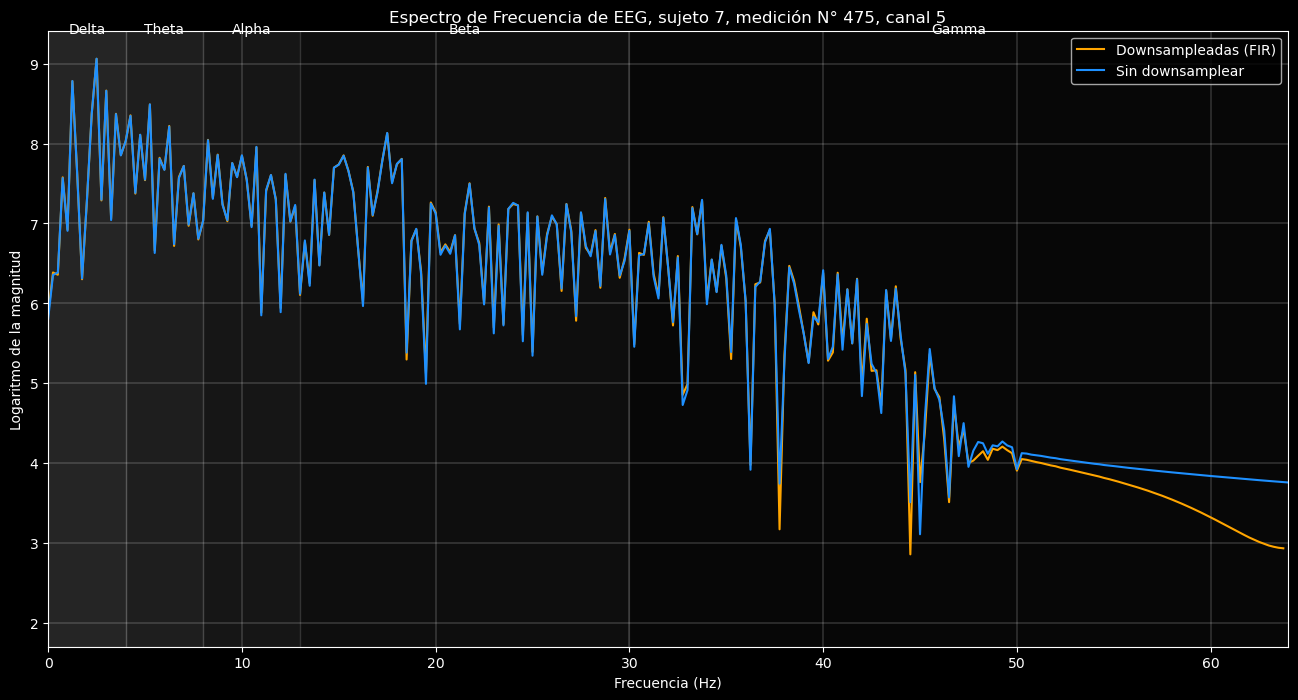

In [131]:
sujeto = random.randint(1, 15)
# sujeto = 14
datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)
fs = 1024
dato = random.randint(0, datos_ordenados[0].shape[0] - 1)
# dato = 634
canal = random.randint(0, 5)
# canal = 3

indice = (datos_ordenados[1][dato] - 1).astype(int)
ref_etiq = [['Imaginada', 'Pronunciada'][indice[0]], ['A', 'E', 'I', 'O', 'U', 'Arriba', 'Abajo', 'Adelante', 'Atras', 'Derecha', 'Izquierda'][indice[1]], ['Limpio', 'Parpadeo'][indice[2]]]
ref_etiq = str(ref_etiq[0]) + ' - ' + str(ref_etiq[1]) + ' - ' + str(ref_etiq[2])

###########################################################################################################################################################
# Le hago un downsampling a los datos

fs_original = 1024
fs_nueva = 128
factor = fs_original // fs_nueva
datos_downsampleados = [np.empty((datos_ordenados[0].shape[0], fs_nueva*4*6)), datos_ordenados[1]]
for i in range(6):  # Se hace por canal en cada una de las mediciones
    datos_downsampleados[0][:,fs_nueva*4*i:fs_nueva*4*(i + 1)] = decimate(
        datos_ordenados[0][:,4*fs_original*i:4*fs_original*(i + 1)], factor, axis = 1, ftype = 'fir', zero_phase = True)

# datos_downsampleados2 = [np.empty((datos_ordenados[0].shape[0], fs_nueva*4*6)), datos_ordenados[1]]
# for i in range(6):  # Se hace por canal en cada una de las mediciones
#     datos_downsampleados2[0][:,fs_nueva*4*i:fs_nueva*4*(i + 1)] = decimate(
#         datos_ordenados[0][:,4*fs_original*i:4*fs_original*(i + 1)], factor, axis = 1, zero_phase = True)

###########################################################################################################################################################
# Grafico valores

plt.figure(figsize=(18, 8))
plt.style.use('dark_background')
plt.plot(np.linspace(0, 4, 4*fs_nueva), datos_downsampleados[0][dato][canal*4*fs_nueva:(canal + 1)*4*fs_nueva], color = 'orange')
#plt.plot(np.linspace(0, 4, 4*fs_nueva), datos_downsampleados2[0][dato][canal*4*fs_nueva:(canal + 1)*4*fs_nueva], color = 'green')
plt.plot(np.linspace(0, 4, 4*fs_original), datos_ordenados[0][dato][canal*4*fs_original:(canal + 1)*4*fs_original], color = 'dodgerblue')
plt.title("Valores de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(dato + 1) + ', canal ' + str(canal))
plt.xlabel("Tiempo [s]")
plt.ylabel("Magnitud")
plt.text(4.0, 1.3*np.max(datos_ordenados[0][dato][canal*4*fs_original:(canal + 1)*4*fs_original]), 
         ref_etiq, fontsize=10, ha='right', va='top', bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.xlim(-0.1, 4.1)
plt.show()

##########################################################################################################################################################
# Grafico de frecuencias

magnitudes_fft_downsampleadas = np.abs(np.fft.fft(datos_downsampleados[0][dato][canal*fs_nueva*4:(canal + 1)*fs_nueva*4]))
frecuencias_downsampleadas = np.fft.fftfreq(len(datos_downsampleados[0][dato][canal*fs_nueva*4:(canal + 1)*fs_nueva*4]), d = 1/fs_nueva)
magnitudes_fft_downsampleadas = magnitudes_fft_downsampleadas[:len(frecuencias_downsampleadas)//2]
frecuencias_downsampleadas = frecuencias_downsampleadas[:len(frecuencias_downsampleadas)//2]

# magnitudes_fft_downsampleadas2 = np.abs(np.fft.fft(datos_downsampleados[0][dato][canal*fs_nueva*4:(canal + 1)*fs_nueva*4]))
# frecuencias_downsampleadas2 = np.fft.fftfreq(len(datos_downsampleados[0][dato][canal*fs_nueva*4:(canal + 1)*fs_nueva*4]), d = 1/fs_nueva)
# magnitudes_fft_downsampleadas2 = magnitudes_fft_downsampleadas2[:len(frecuencias_downsampleadas2)//2]
# frecuencias_downsampleadas2 = frecuencias_downsampleadas2[:len(frecuencias_downsampleadas2)//2]

magnitudes_fft_sin_downsamplear = np.abs(np.fft.fft(datos_ordenados[0][dato][canal*fs_original*4:(canal + 1)*fs_original*4]))
frecuencias_sin_downsamplear = np.fft.fftfreq(len(datos_ordenados[0][dato][canal*fs_original*4:(canal + 1)*fs_original*4]), d = 1/fs_original)
magnitudes_fft_sin_downsamplear = magnitudes_fft_sin_downsamplear[:len(frecuencias_sin_downsamplear)//2]
frecuencias_sin_downsamplear = frecuencias_sin_downsamplear[:len(frecuencias_sin_downsamplear)//2]

plt.figure(figsize=(16, 8))
plt.style.use('dark_background')
ondas_cerebrales = [
    {"nombre": "Delta", "inicio": 0, "fin": 4, 'tr': 0.15},
    {"nombre": "Theta", "inicio": 4, "fin": 8, 'tr': 0.12},
    {"nombre": "Alpha", "inicio": 8, "fin": 13, 'tr': 0.09},
    {"nombre": "Beta", "inicio": 13, "fin": 30, 'tr': 0.06},
    {"nombre": "Gamma", "inicio": 30, "fin": 64, 'tr': 0.03}
]
for onda in ondas_cerebrales:
    plt.axvspan(onda["inicio"], onda["fin"], color = 'white', alpha = onda['tr'])
    x_pos = (onda["inicio"] + onda["fin"]) / 2
    y_pos = 1.05*max(np.log(magnitudes_fft_sin_downsamplear))
    plt.text(x_pos, y_pos, onda["nombre"], fontsize=10, ha='center', va='top', color='white')

plt.plot(frecuencias_downsampleadas, np.log(magnitudes_fft_downsampleadas*8), label = 'Downsampleadas (FIR)', color = 'orange')
#plt.plot(frecuencias_downsampleadas, np.log(magnitudes_fft_downsampleadas2*8), label = 'Downsampleadas (IIR)', color = 'green')
plt.plot(frecuencias_sin_downsamplear, np.log(magnitudes_fft_sin_downsamplear), label = 'Sin downsamplear', color = 'dodgerblue')
plt.xlim(0, 64)
plt.title("Espectro de Frecuencia de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(dato + 1) + ', canal ' + str(canal))
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Logaritmo de la magnitud")
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()



Probemos usar el metodo de stft sin downsamplear

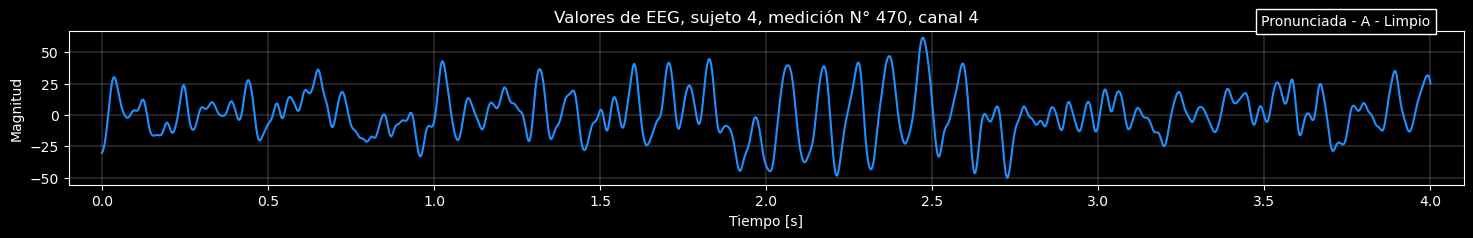

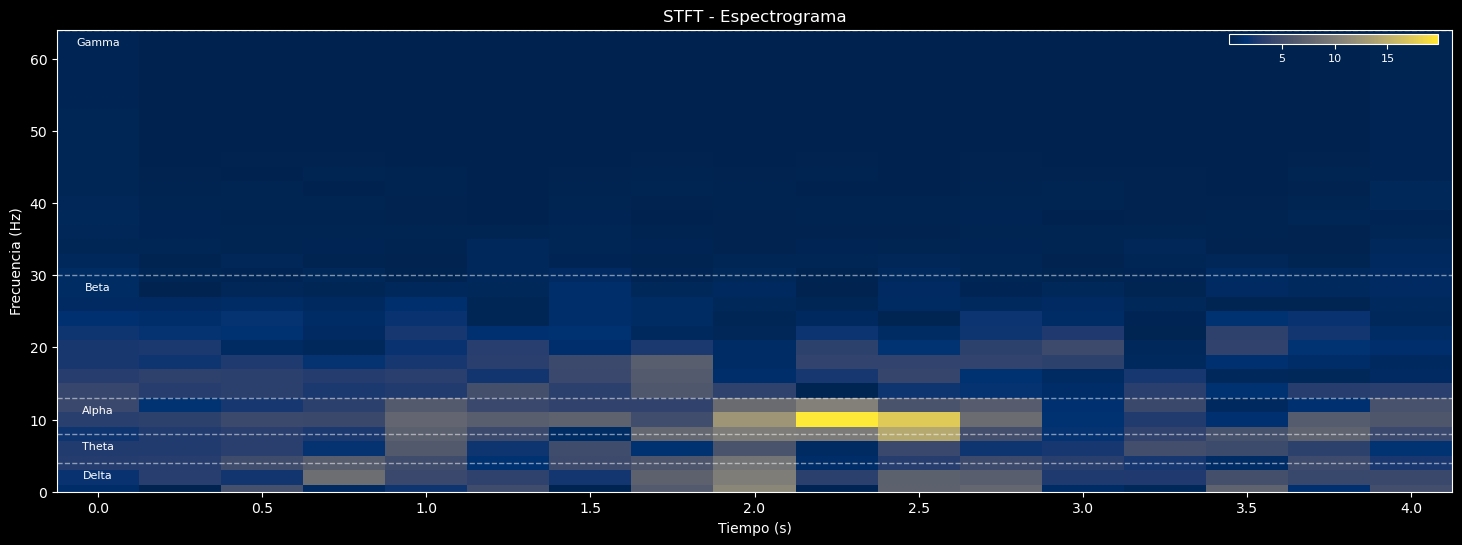

In [237]:
sujeto = random.randint(1, 15)
# sujeto = 14
datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)
fs = 1024
dato = random.randint(0, datos_ordenados[0].shape[0] - 1)
# dato = 634
canal = random.randint(0, 5)
# canal = 3

fs = 1024

plt.figure(figsize=(18, 2))
plt.style.use('dark_background')
plt.plot(np.linspace(0, 4, 4*fs), datos_ordenados[0][dato][canal*4*fs:(canal + 1)*4*fs], color = 'dodgerblue')
plt.title("Valores de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(dato + 1) + ', canal ' + str(canal))
plt.xlabel("Tiempo [s]")
plt.ylabel("Magnitud")
plt.text(4.0, 1.3*np.max(datos_ordenados[0][dato][canal*4*fs:(canal + 1)*4*fs]), 
         ref_etiq, fontsize=10, ha='right', va='top', bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.xlim(-0.1, 4.1)
plt.show()

ventana_temporal = 512
f, t_stft, Zxx = mifu.calcular_stft(datos_ordenados[0][dato][canal*4*fs:(canal + 1)*4*fs], fs = fs, nperseg = ventana_temporal, noverlap = ventana_temporal/2)

f_max = 64
cmap = 'cividis'
if f_max:
    idx_max = np.where(f <= f_max)[0][-1]  # Encuentra el índice del f_max
    f = f[:idx_max + 1]  # Filtra las frecuencias
    Zxx = Zxx[:idx_max + 1, :]  # Filtra la matriz espectral
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(18, 6))
pcm = ax.pcolormesh(t_stft, f, np.abs(Zxx), shading = 'nearest', cmap = cmap)

# Crear un eje dentro del gráfico para la barra de color (posición relativa)
cax = ax.inset_axes([0.84, 0.97, 0.15, 0.02])
cbar = plt.colorbar(pcm, cax = cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 8)
# Límites de ondas cerebrales
bandas = {
    "Delta": 4,
    "Theta": 8,
    "Alpha": 13,
    "Beta": 30,
    "Gamma": 64
}
for label, freq in bandas.items():
    ax.axhline(y = freq, color = 'white', linestyle = 'dashed', alpha = 0.5, linewidth = 1)  # Línea horizontal
    ax.text(t_stft[0], freq - 1, label, color = 'white', fontsize = 8, verticalalignment = 'top', horizontalalignment = 'center')

ax.set_ylabel('Frecuencia (Hz)')
ax.set_xlabel('Tiempo (s)')
ax.set_title(f'STFT - Espectrograma')
ax.set_ylim(0, f_max)

plt.show()

In [270]:
fecha1 = '05-03-2025'
hito1 = 'Modulo del espectograma STFT sin downsampling ni filtrado.'
N = 8
for sujeto in range(1, 16):
    datos = mifu.extraer(sujeto)
    datos_ordenados = mifu.ordenar(datos)
    fs = 1024

    tam_f = 33
    ventana_temporal = 512
    datos_stft = mifu.convertir_a_stft(datos_ordenados, fs, 'hann', ventana_temporal, ventana_temporal/2)
    datos_stft[0] = datos_stft[0][:, :, :tam_f, :]

    datos_aplanados = np.empty((datos_stft[0].shape[0], datos_stft[0].shape[1]*datos_stft[0].shape[2]*datos_stft[0].shape[3])).astype(np.complex128())
    aux = np.empty((datos_stft[0].shape[0], datos_stft[0].shape[1], datos_stft[0].shape[2]*datos_stft[0].shape[3])).astype(np.complex128())
    for i in range(datos_stft[0].shape[0]):
        for j in range(datos_stft[0].shape[1]):
            aux[i][j] = np.concatenate(datos_stft[0][i][j].T)
    for i in range(aux.shape[0]):
        datos_aplanados[i] = np.concatenate(aux[i])
    datos_aplanados = [datos_aplanados, datos_stft[1]]
    datos_aplanados = [np.abs(datos_aplanados[0]), datos_aplanados[1]]

    datos_normalizados1 = mifu.normalizar(datos_aplanados)

    for prediccion in ['estimulo']:
        if prediccion == 'modalidad' or prediccion == 'artefacto':
            fraccion_entrenamiento = 0.40
            neuronas_salida = 2
        else:
            fraccion_entrenamiento = 0.25
            neuronas_salida = 11

        valores1 = []
        for n in range(N):
            semilla = random.randint(0, 999999)

            datos_divididos1 = mifu.dividir_datos(datos_normalizados1, fraccion_entrenamiento, prediccion, semilla)

            neuronas_entrada1 = datos_divididos1[0][0].shape[1]
            ocultas = [256, 128]
            epocas = 3000       # Al tener menos neuronas en la capa de entrada, puedo ponerle mas tiempo de entrenamiento
            plotear = 0         # Si es 1 grafica la perdida, si es 0 no lo hace
            tol = 1e-5
            ls = 0.0001
            datos_divididos1[0][0], datos_divididos1[0][1] = shuffle(datos_divididos1[0][0], datos_divididos1[0][1], random_state = semilla)

            dropout_ratio = 0.0     # Tuve que sacarle el dropout porque me cumplia el criterio de parada siempre
            modelo1 = mifu.MLP(neuronas_entrada1, ocultas, neuronas_salida, dropout_ratio)
            mifu.MLP.entrenar(modelo1, epocas, datos_divididos1[0][0], datos_divididos1[0][1], plotear, tol, ls)

            precision1, predicciones1 = mifu.MLP.evaluar(modelo1, datos_divididos1[1][0], datos_divididos1[1][1])
            print(np.bincount(predicciones1), np.bincount(datos_divididos1[1][1]))
            valores1.append(precision1)

        error1 = np.std(valores1, ddof=1)/math.sqrt(N)
        valor1 = np.mean(valores1)
        arq1 = 'S' + str(sujeto) + '/' + 'minmax' + '/' + prediccion + '/' + str([neuronas_entrada1] + ocultas + [neuronas_salida]).replace(',','')
        mifu.registrar(valor1, error1, arq1, fecha1, hito1)


Se usara el 22% para entrenar al modelo.
La precision del modelo es del 10.86142%.
[80 62 45 46 55 70 31 39 32 50 24] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 11.98502%.
[53 49 38 50 32 54 29 62 51 43 73] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 10.48689%.
[40 55 63 43 51 68 41 30 37 45 61] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 12.17228%.
[61 51 43 44 51 57 46 45 37 32 67] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 14.60674%.
[84 39 47 52 60 48 50 36 32 44 42] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 15.54307%.
[37 56 50 58 40 36 63 44 36 62 52] [56 49 53 52 51 48 47 44 46 44 44]
Se usara el 22% para entrenar al modelo.
La precision del modelo es del 11.61049%.

Me entere que normalmente se suele entrenar con el 70% de los datos, en lugar del 25%, asi que voy a probar cambiar eso.

In [5]:
sujeto = random.randint(1, 15)
datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)

fs = 1024
tam_f = 33
ventana_temporal = 512
datos_stft = mifu.convertir_a_stft(datos_ordenados, fs, 'hann', ventana_temporal, ventana_temporal/2)
datos_stft[0] = datos_stft[0][:, :, :tam_f, :]

datos_aplanados = np.empty((datos_stft[0].shape[0], datos_stft[0].shape[1]*datos_stft[0].shape[2]*datos_stft[0].shape[3])).astype(np.complex128())
aux = np.empty((datos_stft[0].shape[0], datos_stft[0].shape[1], datos_stft[0].shape[2]*datos_stft[0].shape[3])).astype(np.complex128())
for i in range(datos_stft[0].shape[0]):
    for j in range(datos_stft[0].shape[1]):
        aux[i][j] = np.concatenate(datos_stft[0][i][j].T)
for i in range(aux.shape[0]):
    datos_aplanados[i] = np.concatenate(aux[i])
datos_aplanados = [datos_aplanados, datos_stft[1]]
datos_aplanados = [np.abs(datos_aplanados[0]), datos_aplanados[1]]

datos_normalizados = mifu.normalizar(datos_aplanados)

prediccion = 'estimulo'
fraccion_entrenamiento = 0.70
if prediccion == 'modalidad' or prediccion == 'artefacto':
    neuronas_salida = 2
elif prediccion == 'estimulo':
    neuronas_salida = 11

semilla = random.randint(0, 999999)
datos_divididos = mifu.dividir_datos(datos_normalizados, fraccion_entrenamiento, prediccion, semilla)

neuronas_entrada = datos_divididos[0][0].shape[1]
ocultas = [480, 120, 30]
epocas = 3000       # Al tener menos neuronas en la capa de entrada, puedo ponerle mas tiempo de entrenamiento
plotear = 0         # Si es 1 grafica la perdida, si es 0 no lo hace
tol = 1e-5
ls = 0.0001
dropout_ratio = 0.00     # Tuve que sacarle el dropout porque me cumplia el criterio de parada siempre
datos_divididos[0][0], datos_divididos[0][1] = shuffle(datos_divididos[0][0], datos_divididos[0][1], random_state = semilla)

modelo = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida, dropout_ratio)
mifu.MLP.entrenar(modelo, epocas, datos_divididos[0][0], datos_divididos[0][1], plotear, tol, ls)

precision, predicciones = mifu.MLP.evaluar(modelo, datos_divididos[1][0], datos_divididos[1][1])
print(np.bincount(predicciones), np.bincount(datos_divididos[1][1]))

Se usara el 65% para entrenar al modelo. Son 38 datos de c/u.
La precision del modelo es del 12.10762%.
[16 19 27 32 11 12 11 35 23 21 16] [17 18 19 20 17 21 23 23 21 23 21]


Voy a probar extraer algunas features

In [1]:
sujeto = random.randint(1, 15)
datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)

fs = 1024
ventana_temporal = 512
datos_stft = mifu.convertir_a_stft(datos_ordenados, fs, 'hann', ventana_temporal, ventana_temporal/2)
bandas = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 64)
}
datos_potencia_bandas = mifu.convertir_a_potencia_bandas(datos_stft, bandas)
datos_normalizados = mifu.normalizar(datos_potencia_bandas)

prediccion = 'estimulo'
if prediccion == 'modalidad' or prediccion == 'artefacto':
    fraccion_entrenamiento = 0.40
    neuronas_salida = 2
elif prediccion == 'estimulo':
    fraccion_entrenamiento = 0.25
    neuronas_salida = 11

semilla = random.randint(0, 999999)
datos_divididos = mifu.dividir_datos(datos_normalizados, fraccion_entrenamiento, prediccion, semilla)

neuronas_entrada = datos_divididos[0][0].shape[1]
ocultas = [480, 120, 30]
epocas = 3000       # Al tener menos neuronas en la capa de entrada, puedo ponerle mas tiempo de entrenamiento
plotear = 0         # Si es 1 grafica la perdida, si es 0 no lo hace
tol = 1e-5
ls = 0.0001
dropout_ratio = 0.01     # Tuve que sacarle el dropout porque me cumplia el criterio de parada siempre
datos_divididos[0][0], datos_divididos[0][1] = shuffle(datos_divididos[0][0], datos_divididos[0][1], random_state = semilla)

modelo = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida, dropout_ratio)
mifu.MLP.entrenar(modelo, epocas, datos_divididos[0][0], datos_divididos[0][1], plotear, tol, ls)

precision, predicciones = mifu.MLP.evaluar(modelo, datos_divididos[1][0], datos_divididos[1][1])
print(np.bincount(predicciones), np.bincount(datos_divididos[1][1]))

NameError: name 'random' is not defined